#### Franka Cabinet Notebook

Imports first

In [1]:
import matplotlib.pyplot as plt
import gym
from IPython import display
import numpy as np
import onnx
import onnxruntime as ort
import pandas as pd
import shap


shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Load the ONNX model

Franka Environment has 23 float observations, and has 9 float action space

In [22]:
ort_model = ort.InferenceSession("resources/FRANKA_CAB/frankacab.onnx")

outputs = ort_model.run(
    None,
    {"obs": np.zeros((1, 23)).astype(np.float32)},
)

features_name_panda = ['dof1','dof2','dof3','dof4','dof5','dof6','dof7','grip1','grip2','missing1','missing2','missing3','missing4','missing5','dist_to_handleX','dist_to_handleY','dist_to_handleZ','cabX','cabY','cabZ','cabLVX','cabLVY','cabLVZ']

print(outputs)

[array([[ 2.7263985e+00, -4.0817273e-01, -1.8529590e+00,  1.3452005e-03,
        -9.9250615e-01,  1.5114992e+00,  2.5053966e+00,  1.1044590e+00,
        -1.4369296e-01]], dtype=float32), array([[-1.155339  , -1.1715786 , -1.4506835 , -1.146622  , -0.55545086,
        -0.9320798 , -0.60048985, -0.7533106 , -0.34114134]],
      dtype=float32), array([[-2.0270646]], dtype=float32)]


We need to create a method that wraps this onnx return

In [3]:
def predict_model(observation):    
   
    outputs = ort_model.run(None, {"obs": np.expand_dims(observation, axis=0).astype(np.float32)},)
    mu = outputs[0].squeeze(0)
    #print(mu)
    #sigma = np.exp(outputs[1].squeeze(0))
    #print(sigma)
    #action = np.random.normal(mu, sigma)
    out_action = np.clip(mu, a_min = -1.0, a_max = 1.0) 
    
    return out_action

In [4]:
def predict_all(observations):
    ret = []
    for x in observations:
        ret.append(predict_model(x))
    ret = np.array(ret)

    return ret

Load in Training Data

In [5]:
training = 'resources/FRANKA_CAB/all_df.csv'
test = 'resources/FRANKA_CAB/single_episode.csv'

all = pd.read_csv(training)
single =  pd.read_csv(test)

all['X'] = [eval(x) for x in all['X']]
all['Y'] = [eval(x) for x in all['Y']]
single['X'] = [eval(x) for x in single['X']]
single['Y'] = [eval(x) for x in single['Y']]




print(all.loc[0].X)
print("----")
print(predict_model(all.loc[0].X))
print("----")
print(all.loc[0].Y)


[0.42502105236053467, -0.5784300565719604, -0.013868093490600586, -0.4821775555610657, -0.6498122811317444, -0.5139548778533936, 0.13244271278381348, 0.9996047019958496, 0.9999983310699463, -3.325566649436951e-05, -0.002896813675761223, -0.0012714677723124623, -0.00730113172903657, 0.0012111171381548047, -0.0002501916023902595, 1.2077067367499694e-05, -1.0742245649453253e-05, 6.115758992564224e-07, -0.4707162082195282, -0.006101896986365318, -0.10857319831848145, 6.9681713732450135e-09, -1.304091057363621e-07]
----
[ 1.         -0.6767956  -1.          0.58107996 -0.38675225  0.8663682
 -1.          1.         -1.        ]
----
[1.0, -0.6767953634262085, -1.0, 0.581080436706543, -0.3867511451244354, 0.8663671016693115, -1.0, 1.0, -1.0]


In [10]:
explainer = shap.KernelExplainer(predict_all, shap.sample(xTrain_np, 50))

shap_values = explainer.shap_values(xTest_np)
print("shap_values =", shap_values)
print("base value =", explainer.expected_value)

df = pd.DataFrame({"shap_values": shap_values,"base_value":  explainer.expected_value})
df.to_csv("resources/FRANKA_CAB/shap_values_franka_cab.csv")

  0%|          | 0/498 [00:00<?, ?it/s]

shap_values = [array([[ 0.11025639,  0.05128622,  0.        , ...,  0.06532866,
         0.38759308,  0.10909392],
       [ 0.13174229,  0.08021624,  0.01963548, ...,  0.07892685,
         0.43147705,  0.10360299],
       [ 0.12132064,  0.08314254,  0.00791775, ...,  0.08323068,
         0.48931024,  0.11316131],
       ...,
       [ 0.11241774, -0.01539518, -0.0160491 , ..., -0.00849156,
        -0.23595612,  0.05317955],
       [ 0.11337581, -0.01560337, -0.01317691, ..., -0.01121083,
        -0.23597802,  0.05140647],
       [ 0.10822102, -0.01371291, -0.01618669, ..., -0.00737538,
        -0.23374987,  0.05165085]]), array([[ 0.07183065, -0.65111277, -0.01083685, ..., -0.12878668,
        -0.02488786,  0.        ],
       [ 0.07647574, -0.63371741, -0.01194345, ..., -0.11394723,
        -0.0308915 ,  0.        ],
       [ 0.07366299, -0.68999183, -0.02300183, ..., -0.10851431,
        -0.00723225,  0.00462125],
       ...,
       [ 0.03323366,  0.06373063,  0.00404934, ..., -0.0018

In [6]:
xTrain_np = np.array(all['X'].tolist())
xTest_np =  np.array(single['X'].tolist())

df = pd.read_pickle("resources/FRANKA_CAB/shap_values_franka_cab.pkl")

explainer = shap.KernelExplainer(predict_all, shap.sample(xTrain_np, 50))

shap_values = df['shap_values'].to_list()
explainer.expected_values = df['base_value'].to_list()


## Cutting off the end

In [25]:
# Cut off the bottom 300 rows
all_cut = pd.read_csv(training).iloc[:-300]
single_cut =  pd.read_csv(test).iloc[:-300]

print(all_cut)
print(single_cut)

all_cut['X'] = [eval(x) for x in all_cut['X']]
all_cut['Y'] = [eval(x) for x in all_cut['Y']]
single_cut['X'] = [eval(x) for x in single_cut['X']]
single_cut['Y'] = [eval(x) for x in single_cut['Y']]

cut_xTrain_np = np.array(all_cut['X'].tolist())
cut_xTest_np =  np.array(single_cut['X'].tolist())

explainer = shap.KernelExplainer(predict_all, shap.sample(cut_xTrain_np, 50))

shap_values = explainer.shap_values(cut_xTest_np)
print("shap_values =", shap_values)
print("base value =", explainer.expected_value)

df_cut = pd.DataFrame({"shap_values": shap_values,"base_value":  explainer.expected_value})


df_cut.to_pickle("resources/FRANKA_CAB/shap_values_franka_cab_cut.pkl")


      Unnamed: 0                                                  X  \
0              0  [0.42502105236053467, -0.5784300565719604, -0....   
1              1  [0.42620182037353516, -0.5792677402496338, -0....   
2              2  [0.4291783571243286, -0.5807492733001709, -0.0...   
3              3  [0.4338860511779785, -0.5830355882644653, -0.0...   
4              4  [0.4400249719619751, -0.5862050652503967, -0.0...   
...          ...                                                ...   
8160        8160  [0.5201750993728638, -1.0000042915344238, -0.2...   
8161        8161  [0.5197489261627197, -1.0000022649765015, -0.2...   
8162        8162  [0.5198842287063599, -0.9999920129776001, -0.2...   
8163        8163  [0.5194793939590454, -0.9999849200248718, -0.2...   
8164        8164  [0.518845796585083, -0.999960720539093, -0.277...   

                                                      Y  
0     [1.0, -0.6767953634262085, -1.0, 0.58108043670...  
1     [1.0, -0.4793470501899719

  0%|          | 0/198 [00:00<?, ?it/s]

shap_values = [array([[ 0.13532137,  0.06275575,  0.04090581, ...,  0.07552332,
         0.36098636,  0.10673461],
       [ 0.14223865,  0.05869487,  0.03294466, ...,  0.09109671,
         0.39479266,  0.10374086],
       [ 0.13477305,  0.06628806,  0.0280249 , ...,  0.09559106,
         0.41813859,  0.11100842],
       ...,
       [ 0.07319559, -0.01869451,  0.01378761, ..., -0.02401942,
        -0.21043046,  0.08825494],
       [ 0.07907084, -0.01713673,  0.0153789 , ..., -0.02697795,
        -0.20915333,  0.15909268],
       [ 0.07553441, -0.01247727,  0.02343012, ..., -0.03161723,
        -0.21941672,  0.16601921]]), array([[ 0.08107201, -0.5922927 , -0.00389404, ..., -0.12987244,
        -0.01985174, -0.00392088],
       [ 0.07504187, -0.58680356, -0.01371449, ..., -0.10729123,
        -0.00876645, -0.00670198],
       [ 0.08150084, -0.63310389, -0.02199063, ..., -0.10576425,
         0.        ,  0.00347694],
       ...,
       [ 0.02889209,  0.08678032, -0.01765176, ..., -0.0019

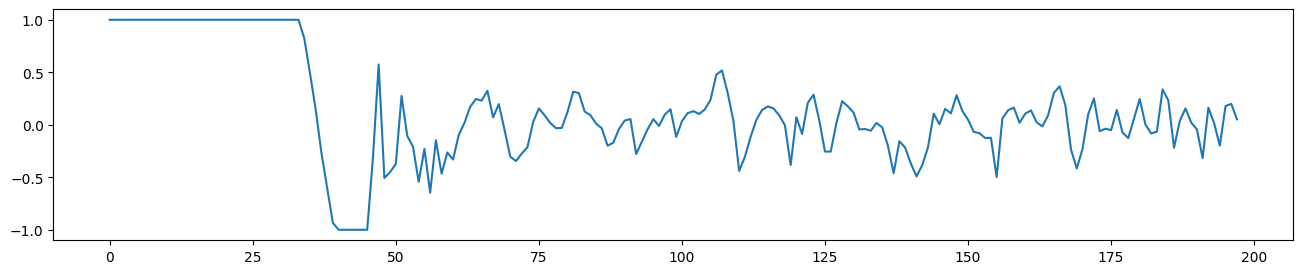

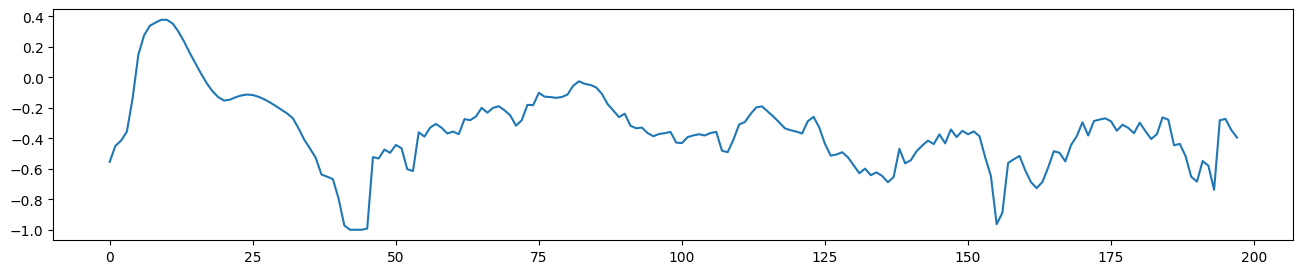

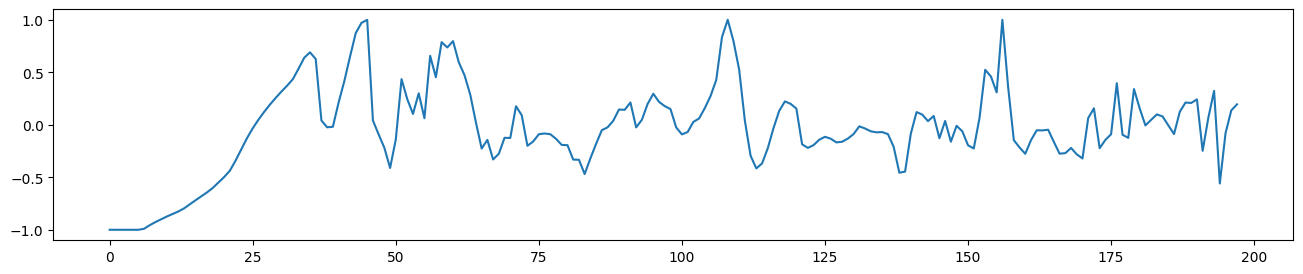

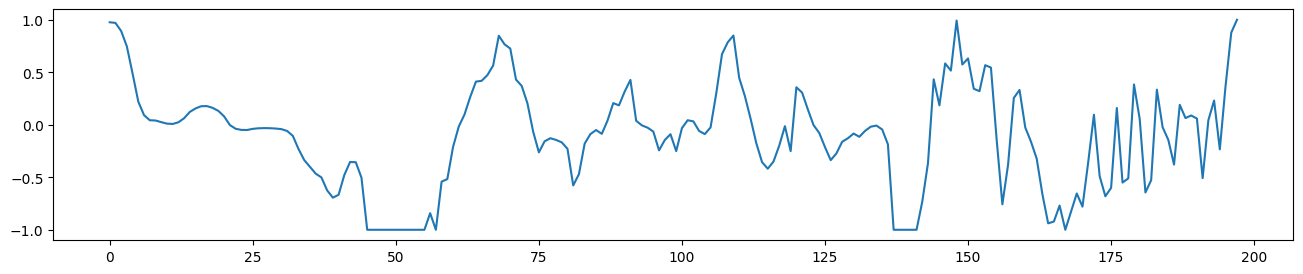

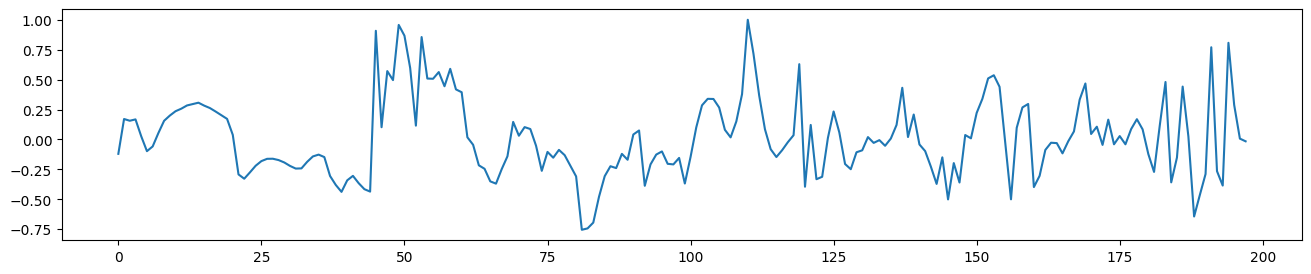

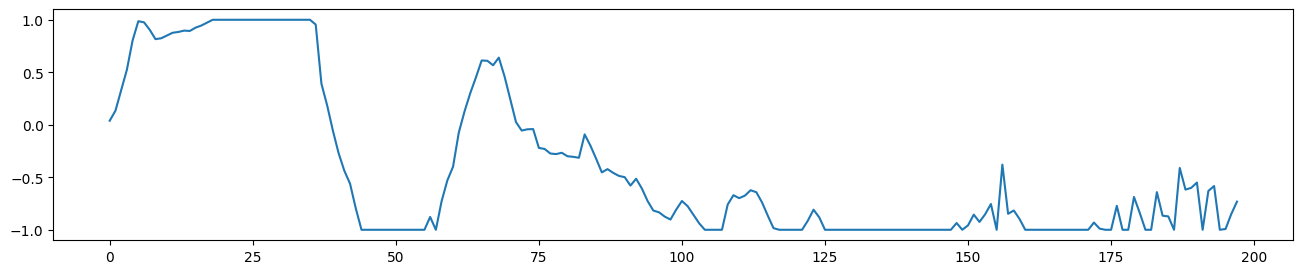

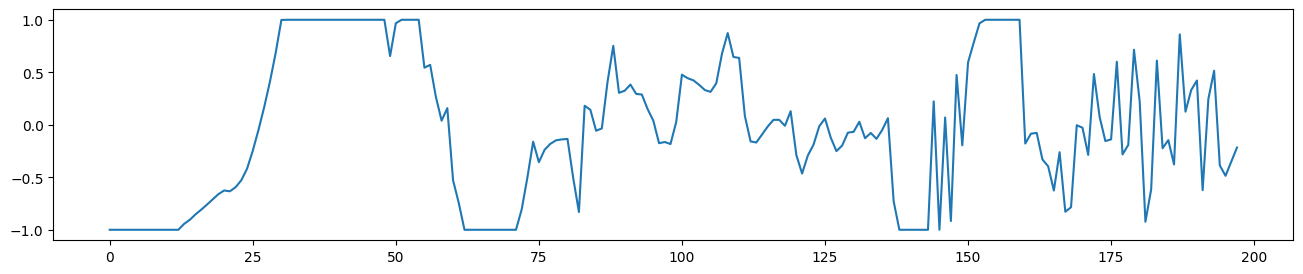

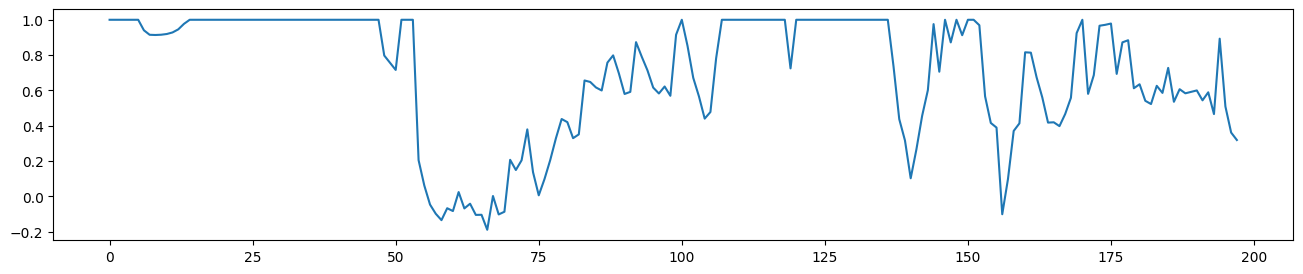

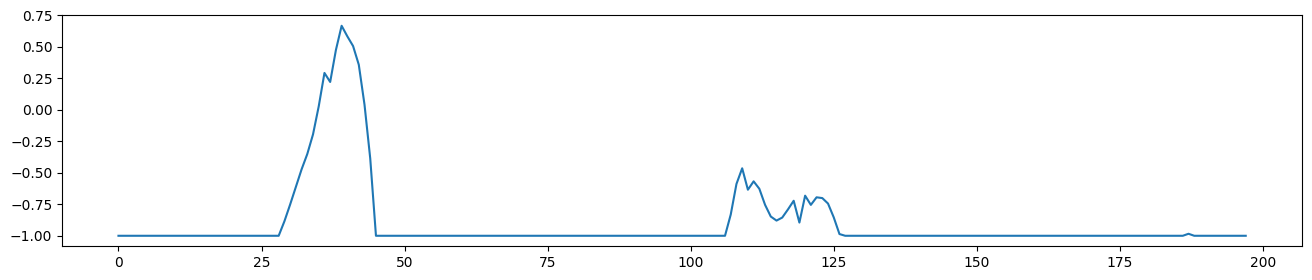

In [29]:
# Action Plot

cmap = plt.colormaps.get_cmap('tab20')
# Generate a linear space of colors
line_colors = cmap(np.linspace(0, 1, 9))


list_action = single['Y'].iloc[:-300].tolist()

for i in range(9):


    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(16, 3))  # Adjust the width and height as needed

    val = [a[i] for a in list_action]

    plt.plot(val)
    
    #plt.legend(features_name_panda, loc='lower right')
    plt.show()




198
[ 0.13532137  0.06275575  0.04090581 -0.06088202  0.00229668  0.04129058
  0.01392049  0.02759411 -0.00848898 -0.01538313  0.          0.02644125
  0.          0.          0.         -0.00900307 -0.00826487 -0.01572015
  0.10411503  0.13271625  0.07552332  0.36098636  0.10673461]


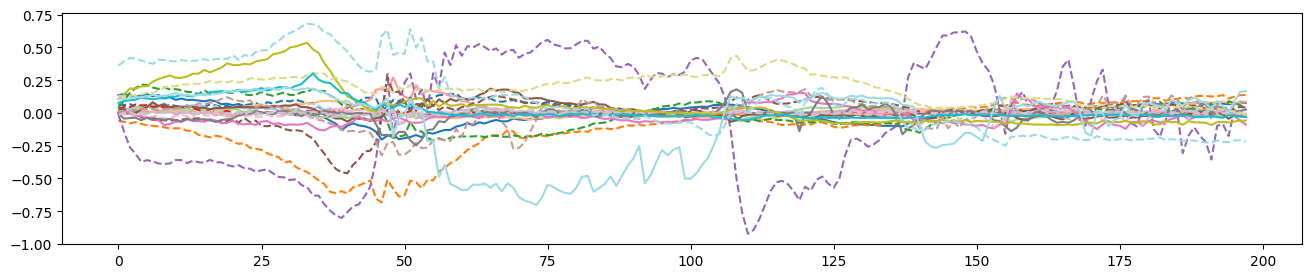

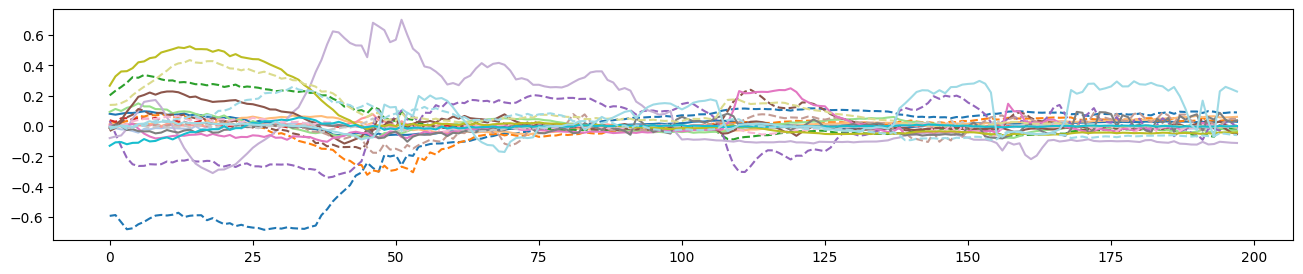

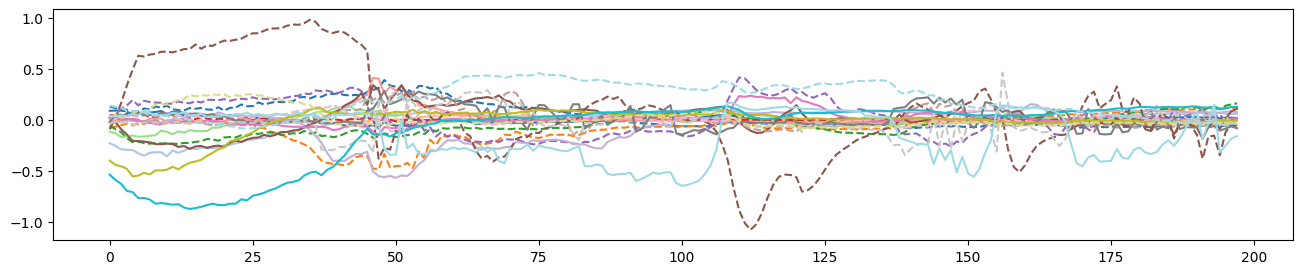

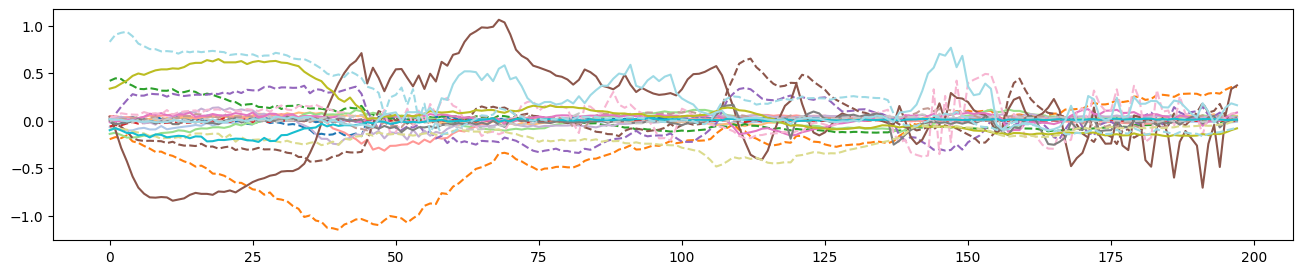

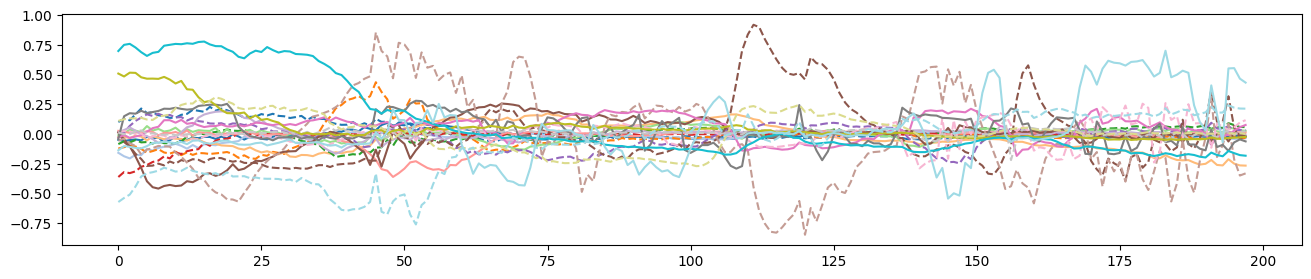

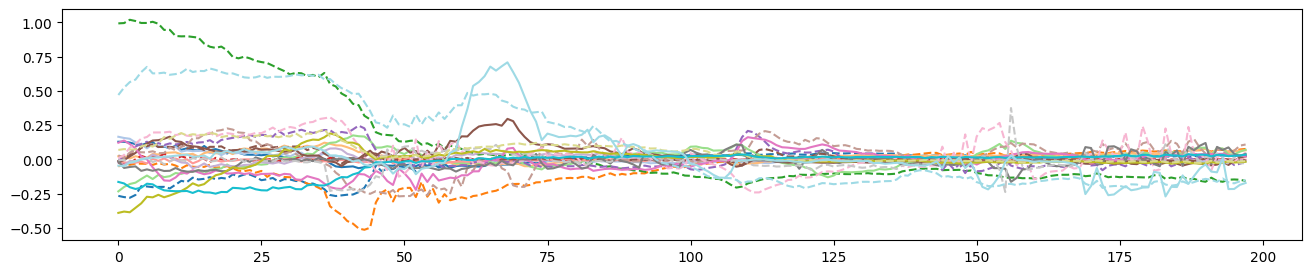

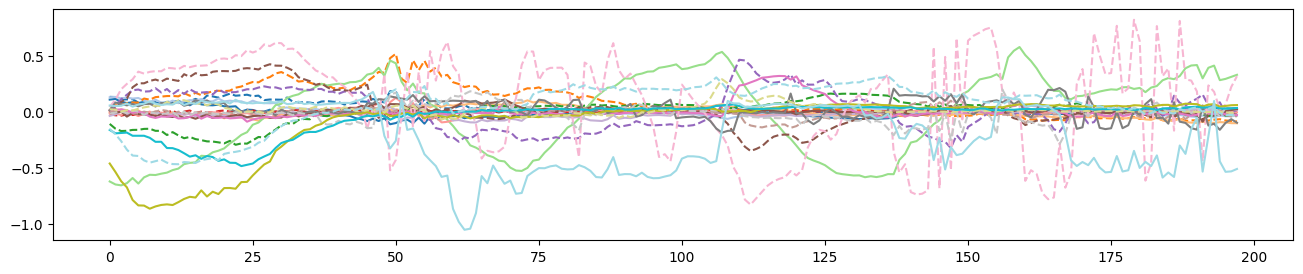

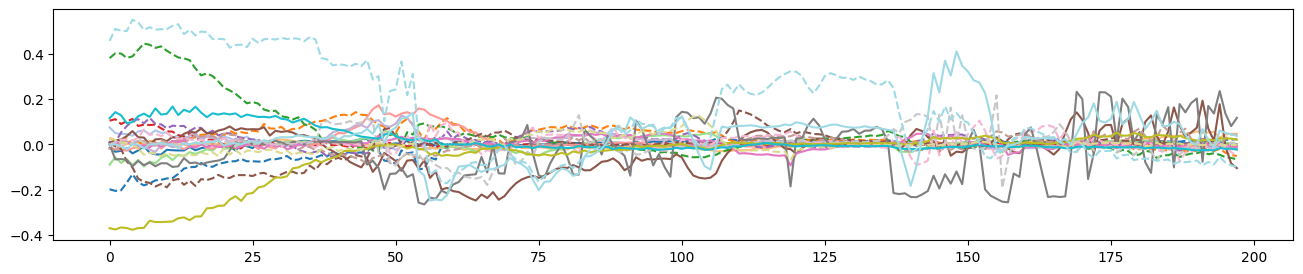

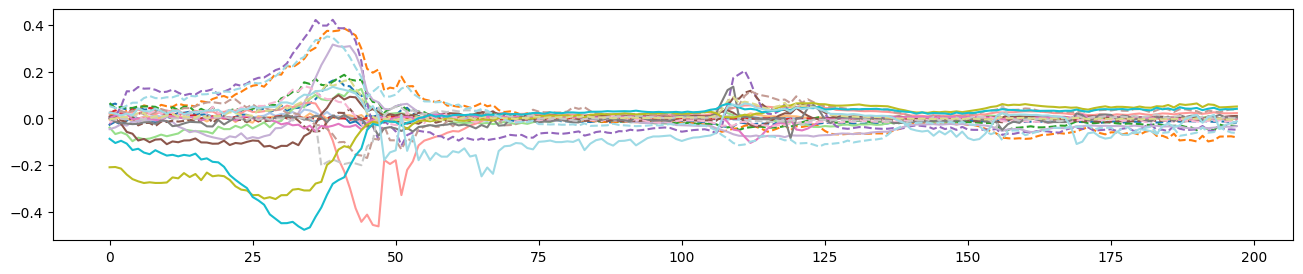

In [27]:
# Choose a colormap
cmap = plt.colormaps.get_cmap('tab20')
# Generate a linear space of colors
line_colors = cmap(np.linspace(0, 1, 23))

print(len(shap_values[0][:,0]))
print(shap_values[0][0])


for i in range(len(shap_values)):        

    # Set the size of the plot
    fig, ax = plt.subplots(figsize=(16, 3))  # Adjust the width and height as needed

    
    # Plot each line with the specified color
    for j in range(len(shap_values[0][0])):

        if j % 2 == 0:
            linestyle = 'solid'  # Make every even line solid
        else:
            linestyle = 'dashed'  # Make every odd line dashed
            
        plt.plot(shap_values[i][:,j], color=line_colors[j],linestyle=linestyle,label=features_name_panda[j])

    #plt.legend(features_name_panda, loc='lower right')
    plt.show()

In [36]:
shap.initjs()

shap.force_plot(explainer.expected_value[3], shap_values[3], xTest_np, feature_names=features_name_panda)

#for i in range(9):
    #shap.force_plot(explainer.expected_value[i], shap_values[i], xTest_np, matplotlib=True)

9
198


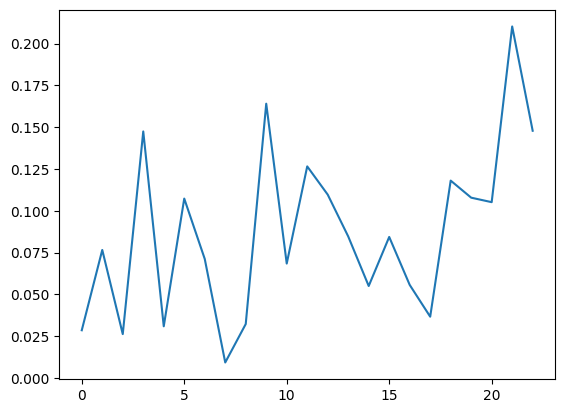

In [30]:
# shap_values return in -> Y return, Episode Number, Obersvation Weight
print(len(shap_values))
print(len(shap_values[0]))

obs_weights = []

for action_index in range(len(shap_values)):
    
    #for episode_index in range(len(shap_values[0])):
    for episode_index in range(0,150):
        
        for value in range(len(shap_values[0][0])):
            if len(obs_weights) != 23:
                obs_weights.append([])
            
            obs_weights[value].append(abs(shap_values[action_index][episode_index][value]))
    
obs_average = []

for observation_list in range(len(obs_weights)):
    obs_average.append([])

    obs_average[observation_list] = sum(obs_weights[observation_list]) / len(obs_weights[observation_list])


plt.plot(obs_average)
plt.show()

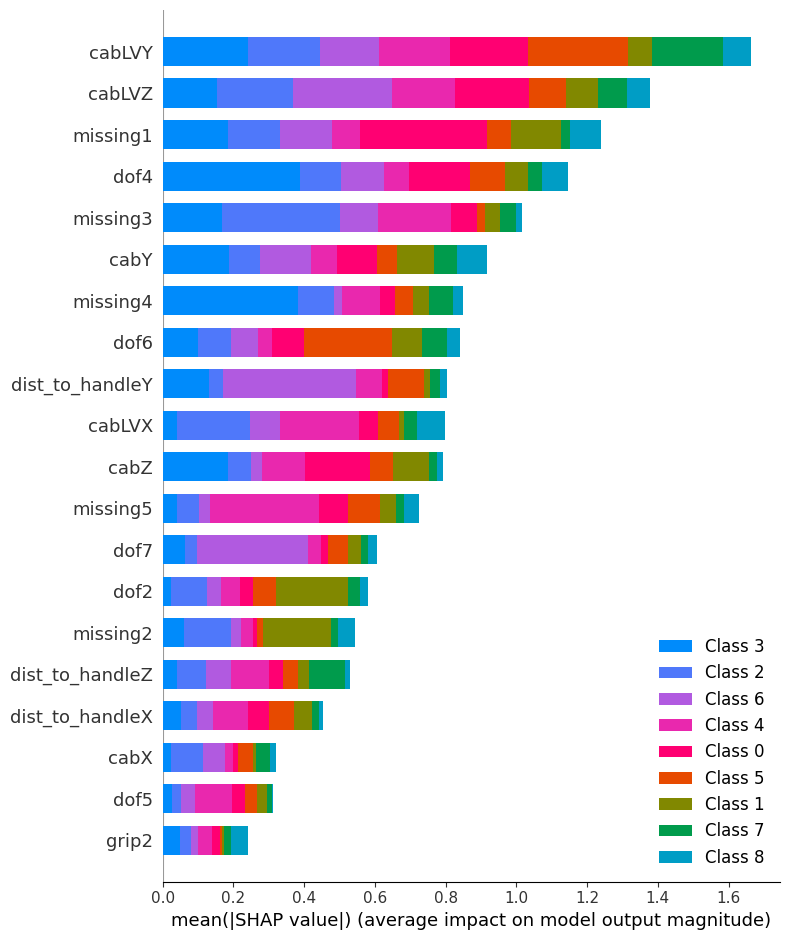

In [37]:
shap.summary_plot(shap_values,cut_xTest_np, plot_type='bar', feature_names=features_name_panda ,max_display=20 )

In [31]:
print(sum(shap_values[0][0])+explainer.expected_value[0])
print(explainer.expected_value[0])

1.0
-0.012859399691224096
